# Домашнее задание «Сверточные нейронные сети: практическое применение»


### Классификация изображений: Cats vs Dogs
Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Шаблон ipython-ноутбука для решения можно скачать [по ссылке](https://github.com/a4tunado/lectures/tree/master/006). Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.
[Датасет](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

In [15]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16

In [16]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)

train_files = glob('data/train/*.jpg')
test_files = glob('data/test/*.jpg')


In [17]:
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)

def fit_generator(files, batch_size=64):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

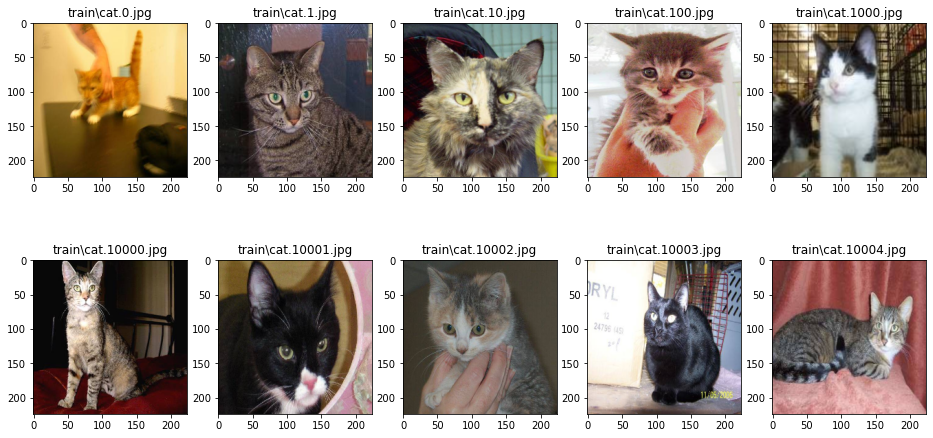

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img);

In [19]:
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [20]:
for layer in base_model.layers:
    layer.trainable = False

In [21]:
x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid',
                                kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

In [22]:
model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-8), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

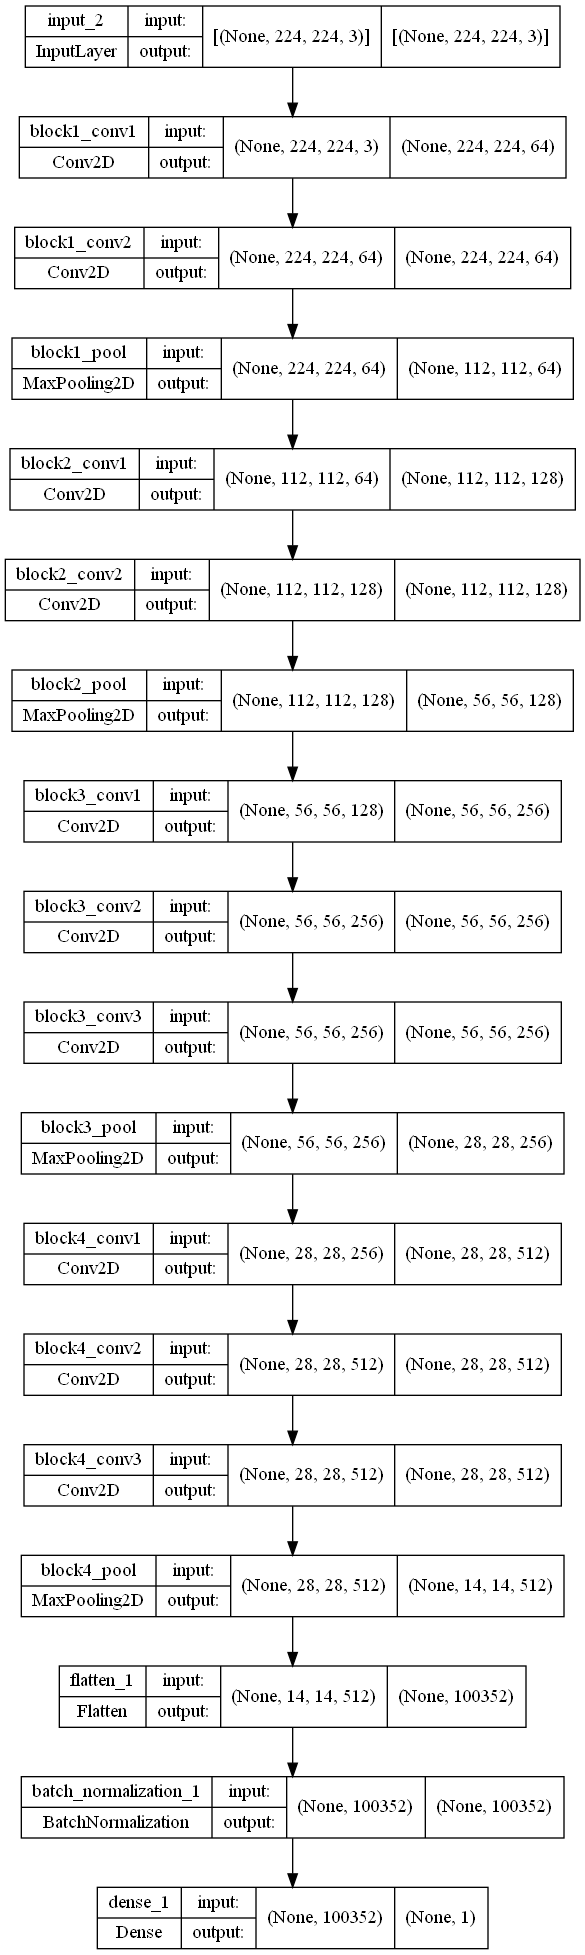

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [25]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                              monitor='val_loss',
                              patience=5,
                              min_delta=1e-7,
                              verbose=2,
                              factor=.5,
                              min_lr=1e-10,
                              mode='auto')

early_stopping = tf.keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              min_delta=1e-7,
                              patience=5,
                              verbose=2,
                              mode='auto',
                              restore_best_weights=False)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                              'model_VGG16_custom.h5',
                              monitor='val_loss',
                              verbose=1, 
                              save_best_only=True, 
                              save_weights_only=True,
                              mode='min')

In [27]:
shuffle(train_files)
validation_data = next(fit_generator(train_files))
train_data = fit_generator(train_files)

In [44]:
hist = model.fit(train_data,
                 batch_size=128,
                 steps_per_epoch=10,
                 epochs=10,
                 validation_data=validation_data,
                 callbacks=[model_checkpoint, reduce_lr, early_stopping])

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.9000 
Epoch 1: val_loss improved from 0.30195 to 0.29765, saving model to model_VGG16_custom.h5
10/10 [==============================] - 149s 15s/step - loss: 0.2752 - accuracy: 0.9000 - val_loss: 0.2976 - val_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.9047 
Epoch 2: val_loss did not improve from 0.29765
10/10 [==============================] - 153s 16s/step - loss: 0.2585 - accuracy: 0.9047 - val_loss: 0.2977 - val_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.9266 
Epoch 3: val_loss improved from 0.29765 to 0.29656, saving model to model_VGG16_custom.h5
10/10 [==============================] - 133s 13s/step - loss: 0.2537 - accuracy: 0.9266 - val_loss: 0.2966 - val_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 4/10
10/10 [==========================

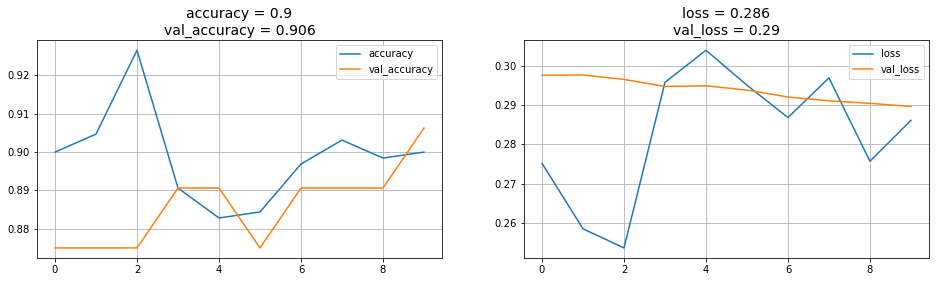

In [45]:
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title(('accuracy = {}\nval_accuracy = {}'.format(round(hist.history['accuracy'][-1],3), 
                                                   round(hist.history['val_accuracy'][-1],3))), fontsize=14)
plt.grid(True)
plt.subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title(('loss = {}\nval_loss = {}'.format(round(hist.history['loss'][-1],3), 
                                           round(hist.history['val_loss'][-1],3))), fontsize=14)
plt.grid(True)
plt.show()

In [46]:
model.load_weights('model_VGG16_custom.h5')

In [48]:
test_pred = model.predict(predict_generator(test_files),
                          steps=len(test_files))

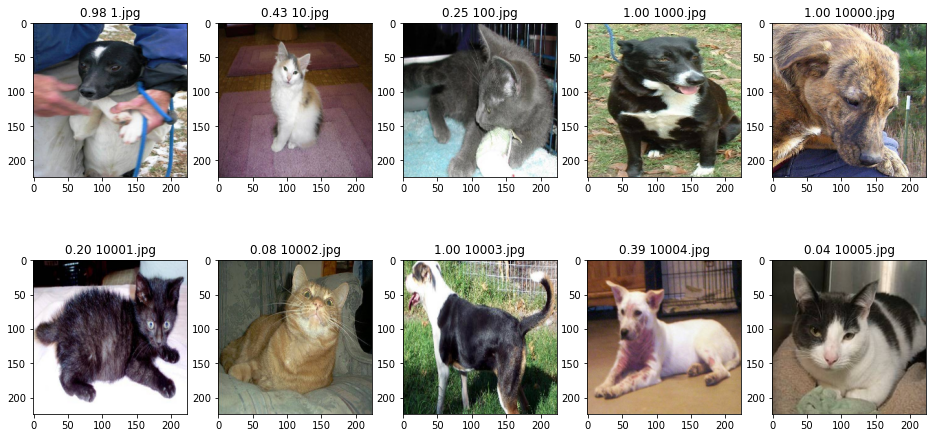

In [49]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [50]:
import pandas as pd
import re

submission = pd.DataFrame(columns=['id', 'label'], index=[i for i in range(len(test_pred))])

for name, score, row in zip(test_files, test_pred, range(len(test_pred))):
    submission.loc[row]['id'] = int(re.findall(r'data/test\\(\d+).jpg', name)[0])
    submission.loc[row]['label'] = float(np.round(score, decimals=5))

submission.head()


,id,label
0,1,0.97832
1,10,0.42608
2,100,0.25004
3,1000,0.999
4,10000,0.99515


In [51]:
submission.to_csv('submission.csv', index=False)

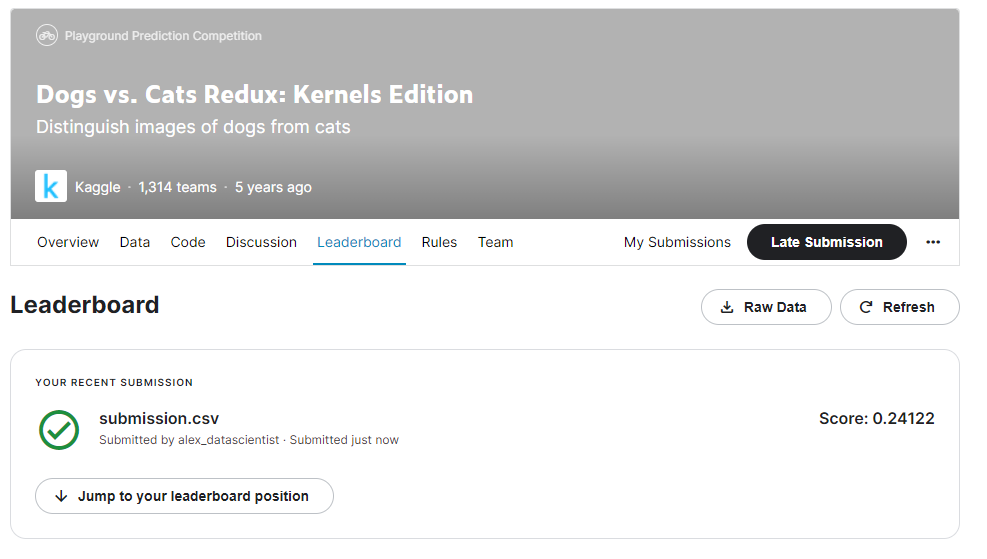

In [52]:
from IPython.display import Image
Image(filename='submission_score.png')
